In [269]:
import numpy as np
from density_correlations import oil_density
from data import roW, d15_6, Mm1
from solubility import Henry_coefficient2_fun, Henry_coefficient4_fun
from mass_balance_equations import k1SaS_fun, k2SaS_fun, k4SaS_fun, k2L_aL_fun, k4L_aL_fun
from kinetics import rHDS_fun, rHDN_NB_fun, rHDN_B_fun, rHDA_fun, ft_reactants, effective_reactions
from bvp import OrthogonalCollocation
from scipy.integrate import solve_ivp
from scipy.optimize import root

In [270]:
class Reactor:

    def __init__(self, z = 31.54, dp = 0.254,  reactor_diameter = 2.54):

        self.z = z
        self.reactor_diameter = reactor_diameter
        self.Ac = np.pi * self.reactor_diameter**2 / 4
        self.V_reactor = self.Ac * z
        self.dp = dp
        self.porosity = self.get_bed_fraction()
        self.aS = self.aS_fun(self.porosity)

    def get_bed_fraction(self):

        return 0.38 + 0.073*(1 + (self.reactor_diameter/self.dp - 2)**2/(self.reactor_diameter/self.dp)**2)
       
    def aS_fun(self, porosity):

        return 6*(1-porosity)/self.dp

In [271]:
class Fluid:

    def __init__(self, T =653.15 , P = 5.3e5, fi = 356, LHSV=2, API = 22, rhob = 0.8163):

        self.reactor = Reactor()
        self.T = T
        self.P = P
        self.fi = fi
        self.LHSV = LHSV
        self.rho0 = d15_6 * roW
        self.rhoL = oil_density(self.rho0,P,T)
        self.rhob = rhob
        self.henry_H2 = Henry_coefficient2_fun(self.rho0, P,T)
        self.henry_H2S = Henry_coefficient4_fun(self.rho0, P,T)
        self.uL = self.LHSV * self.reactor.z / 3600
        self.GL = self.rhoL * self.uL
        self.uG = self.uL*(1e5/self.P)*(self.T/273.15)*self.fi
        self.kSaS_oil = k1SaS_fun(self.rho0, P, T, API, self.GL, self.reactor.aS)
        self.kSaS_H2 = k2SaS_fun(self.rho0, P, T, API, self.GL, self.reactor.aS)
        self.kSaS_H2S = k4SaS_fun(self.rho0, P, T, API, self.GL, self.reactor.aS)
        self.kLaL_H2 = k2L_aL_fun(self.rho0, P, T, API, self.GL)
        self.kLaL_H2S = k4L_aL_fun(self.rho0, P, T, API, self.GL)


    def mass_balance_gas_phase_H2(self, p2G, C2L, R=8.3145):

        return - self.kLaL_H2 * (p2G / self.henry_H2 - C2L) * R * self.T / self.uG 

    def mass_balance_gas_phase_H2S(self, p4G, C4L, R=8.3145):

        return - self.kLaL_H2S * (p4G / self.henry_H2S- C4L) * R * self.T / self.uG

    def mass_balance_gas_liquid_phase_H2(self, p2G, C2L, C2S):

        return (self.kLaL_H2 * (p2G / self.henry_H2 - C2L) -  self.kSaS_H2 * (C2L - C2S)) / self.uL

    def mass_balance_gas_liquid_phase_H2S(self, p4G, C4L, C4S):
        
        return (self.kLaL_H2S * (p4G / self.henry_H2S - C4L) -  self.kSaS_H2S * (C4L - C4S)) / self.uL

    def mass_balance_liquid(self, C1L, C1S): 

        return - (C1L - C1S) * self.kSaS_oil / self.uL
    
    def wt_to_molar(self, wt):

        return wt*self.rhoL/Mm1


In [272]:
class Concentrations(Fluid):

    def __init__(self, cl0, heterogeneous = False, n_points = 3, ivp_tol=1e-16, method = "hybr", **options):

        super().__init__(T = 653.15, P = 5.3e5, fi = 356, LHSV=2, pH2S=0, API = 22, rhob = 0.8163)

        self.cs0 = cl0
        self.heterogeneous = heterogeneous
        self.method = method

        if heterogeneous:

            self.collocation = OrthogonalCollocation(
                    Concentrations._transport_eq,
                    Concentrations._bc_eq,
                    n_points, 3, x0=0, x1= dp/2)
            
        self.n_points = n_points
        self.ivp_tol = ivp_tol
        
        

    @staticmethod
    def _transport_eq(r, y, dy, d2y, yb, *args): #partial equations
        return d2y - ft_reactants(r, y, *args)
    
    @staticmethod    
    def _bc_eq(r, y, dy, d2y, yb, *args):  #boundary conditions
        return y - yb

    def mass_balance_surface(self, cs, cl, z):

        eff = np.ones(4)

        if self.heterogeneous:

            if z == 0:

                root_method = 'lm'
                cs[cs == 0] = self.ivp_rtol
                y0 = np.column_stack((cs,) * (self.n_points + 1))

            else:
                y0 = self.collocation.y
                root_method = 'lm'

            args_ft = (cs, cl[7], self.T, self.rhoL)
            self.collocation.collocate(y0, args=args_ft, method=root_method)

            args_reactions = (cl[7], self.T, self.rhoL)
            eff = self.collocation.effectiveness(effective_reactions, args_reactions)

        rHDS = rHDS_fun(cs,self.T)
        rHDN_NB = rHDN_NB_fun(cs, self.T, self.rhoL)
        rHDN_B = rHDN_B_fun(cs, self.T, self.rhoL)
        rHDA = rHDA_fun(cs, cl[7], self.T, self.rhoL)

        F = np.empty((7))

        F[0] =  1*eff[0] * self.rhob * rHDS  -  self.kSaS_oil*(cl[0] - cs[0])
        F[1] =  1*eff[1] * rHDN_NB -  self.kSaS_oil * (cl[1] - cs[1])
        F[2] =  -1*eff[2] * rHDN_B -  self.kSaS_oil * (cl[2] - cs[2])
        F[3] =  1*eff[3] * rHDA -  self.kSaS_oil * (cl[3] - cs[3])
        F[4] =  15*eff[0] * self.rhob * rHDS +6*eff[1] * rHDN_NB + 2*eff[2]*rHDN_B+3*eff[3] * rHDA   - self.kSaS_H2 * (cl[4] - cs[4])
        F[5] =  -9 * eff[0] * self.rhob * rHDS   - self.kSaS_H2S * (cl[5] - cs[5])
        F[6] =  -1 * eff[3] * rHDA -  self.kSaS_oil * (cl[6] - cs[6])


        return F  
    
    def get_surface_concentrations(self, cl,z):

        self.cs = root(self.mass_balance_surface, self.cs0, (cl,z), method = self.method).x
        self.cs0 = self.cs

In [273]:
w0 = 0.02 #weigth fraction of sulfur.
w1 = (1284 - 518)*1e-6 #weigth fraction of non basic nitrogen.
w2 = 518*1e-6 #weigth fraction of basic nitrogen.
w3= 0.419 #weigth fraction of aromatic compounds.
pG40 = 5.3
pG50 = 0
cL40 = pG40/Fluid().henry_H2 #inlet concentration of hydrogen in mol/cm^3 .
cL50 = 0 #inlet concentration of hidrogen sulfite in mol/cm^3 .
cL60 = 0 #inlet concentration of naphtneses in mol/cm^3.

y0 = [w0, w1, w2, w3, cL40, cL50, cL60, pG40, pG50]

In [274]:
class Main(Fluid):

    def __init__(self, y0,z=31.54, n_points_integration=100, **options):

        super().__init__(T =653.15 , P = 5.3e5, fi = 356, LHSV=2, pH2S=0, API = 22, rhob = 0.8163)

        y0[0:4] = np.vectorize(self.wt_to_molar)(y0[0:4])
        self.y0 = y0
        self.concentrations = Concentrations(y0[:-2])
        self.sol = None
        self.z = z
        self.n_points_integration = n_points_integration
        self.cL0_profile = None
        self.cL1_profile = None
        self.cL2_profile = None
        self.cL3_profile = None
        self.cL4_profile = None
        self.cL5_profile = None
        self.cL6_profile = None
        self.p4G_profile = None
        self.p5G_profile = None

    def differential_equations(self,cl, pG4, pG5, cs):

        return np.array(
        [self.mass_balance_liquid(cl[0], cs[0]),
        self.mass_balance_liquid(cl[1], cs[1]),
        self.mass_balance_liquid(cl[2], cs[2]),
        self.mass_balance_liquid(cl[3], cs[3]),     
        self.mass_balance_gas_liquid_phase_H2(pG4, cl[4], cs[4]),
        self.mass_balance_gas_liquid_phase_H2S(pG5, cl[5], cs[5]),
        self.mass_balance_liquid(cl[6], cs[6]),
        self.mass_balance_gas_phase_H2(pG4, cl[4]),
        self.mass_balance_gas_phase_H2S(pG5, cl[5])])
    
    def dy(self, z, variables):

        pG4, pG5 = variables[-2:]

        self.concentrations.get_surface_concentrations(variables[:-1], z)
        
        solid_concentrations = self.concentrations.cs

        return self.differential_equations(variables[:-2], pG4, pG5, solid_concentrations)
    
    def solve(self):

        t_span = [0, self.z]
        t_eval = np.linspace(0, self.z, self.n_points_integration)
        self.sol = solve_ivp(self.dy, t_span=t_span, y0=self.y0, t_eval=t_eval, method = "RK45")
        self.cL0_profile,  self.cL1_profile, self.cL2_profile, self.cL3_profile, self.cL4_profile, self.cL5_profile, self.cL6_profile, 
        self.p4G_profile, self.p5G_profile 

        

In [275]:
simulator = Main(y0)
simulator.solve()

In [278]:
cexp_0 = 0.0055*Fluid().rhoL/Mm1

cexp_1 = 758e-6*Fluid().rhoL/Mm1

cexp_2 = 360e-6*Fluid().rhoL/Mm1

cexp_3 = 0.38 * Fluid().rhoL/Mm1

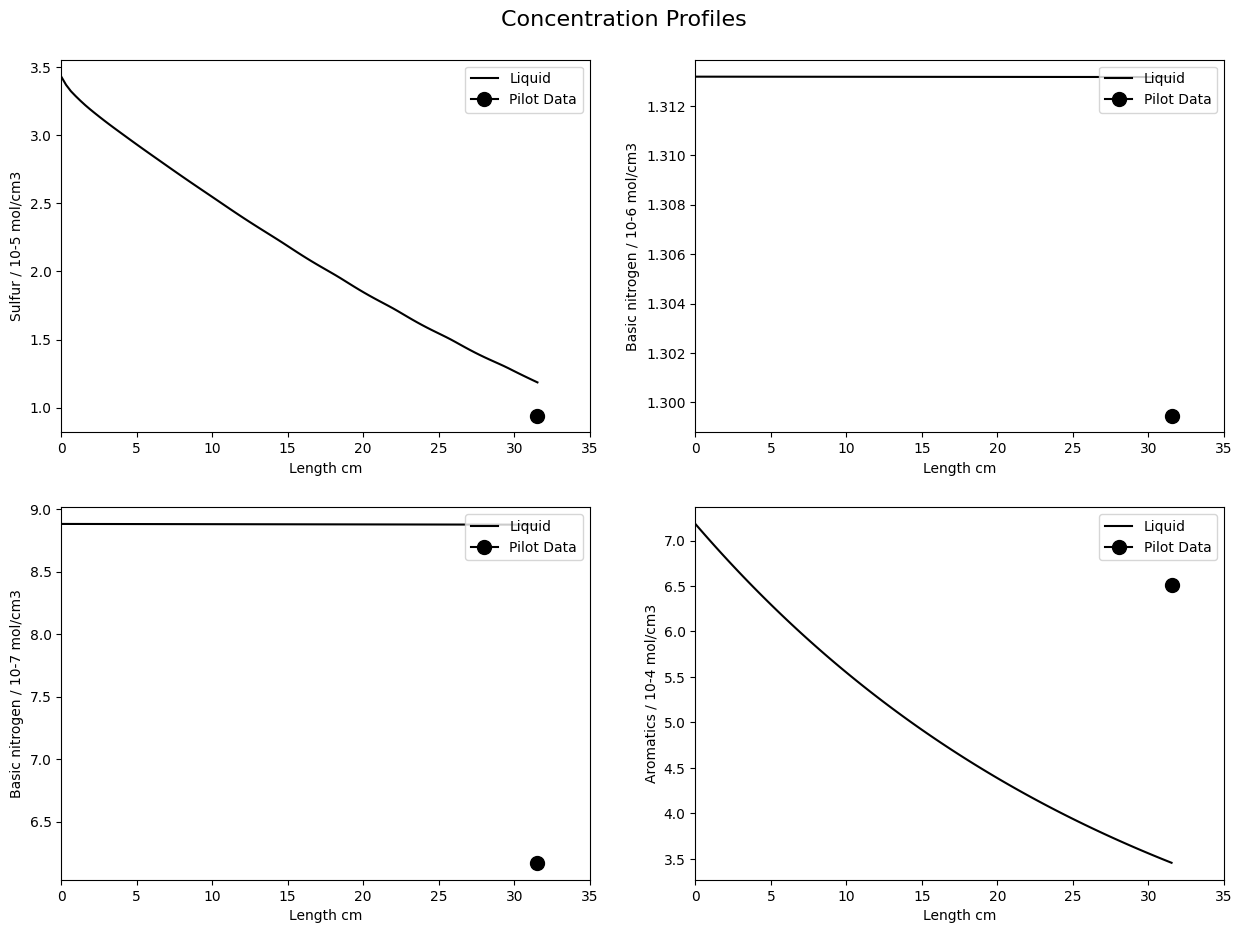

In [279]:
import matplotlib.pyplot as plt

z = 31.54

t_eval = np.linspace(0, 31.54, 100)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the first dataset (y_values1) on the left axis (Y-axis)
ax[0,0].plot(t_eval, cL0_fun*1e5, color='black', label = 'Liquid')
ax[0,0].plot(z, cexp_0*1e5, label = 'Pilot Data', marker = 'o', color='black', markersize=10)

ax[0,0].set_xlim(0,35)
ax[0,0].legend(loc='upper right')

# Add labels and a legend
ax[0,0].set_xlabel('Length cm')
ax[0,0].set_ylabel('Sulfur / 10-5 mol/cm3', color='black')

ax[0,1].plot(t_eval, cL1_fun*1e6, color='black', label = 'Liquid')
ax[0,1].plot(z, cexp_1*1e6, label = 'Pilot Data', marker = 'o', color='black', markersize=10)

ax[0,1].set_xlim(0,35)
ax[0,1].legend(loc='upper right')

# Add labels and a legend
ax[0,1].set_xlabel('Length cm')
ax[0,1].set_ylabel('Basic nitrogen / 10-6 mol/cm3', color='black')

# Add labels and a legend
ax[1,0].set_xlabel('Length cm')
ax[1,0].set_ylabel('Basic nitrogen / 10-7 mol/cm3', color='black')

ax[1,0].plot(t_eval, cL2_fun*1e7, color='black', label = 'Liquid')
ax[1,0].plot(z, cexp_2*1e7, label = 'Pilot Data', marker = 'o', color='black', markersize=10)

ax[1,0].set_xlim(0,35)
ax[1,0].legend(loc='upper right')

# Add labels and a legend
ax[1,0].set_xlabel('Length cm')
ax[1,0].set_ylabel('Basic nitrogen / 10-7 mol/cm3', color='black')

ax[1,1].plot(t_eval, cL3_fun*1e4, color='black', label = 'Liquid')
ax[1,1].plot(z, cexp_3*1e4, label = 'Pilot Data', marker = 'o', color='black', markersize=10)

ax[1,1].set_xlim(0,35)
ax[1,1].legend(loc='upper right')

# Add labels and a legend
ax[1,1].set_xlabel('Length cm')
ax[1,1].set_ylabel('Aromatics / 10-4 mol/cm3', color='black')

# Add a title to the entire figure
plt.suptitle("Concentration Profiles", fontsize=16)

# Adjust spacing between the title and the subplots
plt.subplots_adjust(top=0.93)

# Display the graph
plt.show()